In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

pd.options.display.precision = 4
pd.options.mode.chained_assignment = None

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Flatten, Dense, Dropout
# Machine learning pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# Optuna + pipeline

In [ ]:
df = pd.read_csv('laptop_data.csv')
df.head()

,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,Apple,Ultrabook,8,1.37,11.1758,0,1,226.9830,Intel Core i5,0,128,Intel,Mac
1,Apple,Ultrabook,8,1.34,10.7768,0,0,127.6779,Intel Core i5,0,0,Intel,Mac
2,HP,Notebook,8,1.86,10.3299,0,0,141.2120,Intel Core i5,0,256,Intel,Others
3,Apple,Ultrabook,16,1.83,11.8145,0,1,220.5346,Intel Core i7,0,512,AMD,Mac
4,Apple,Ultrabook,8,1.37,11.4731,0,1,226.9830,Intel Core i5,0,256,Intel,Mac


In [ ]:
df.shape

(1273, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1273 non-null   object 
 1   TypeName     1273 non-null   object 
 2   Ram          1273 non-null   int64  
 3   Weight       1273 non-null   float64
 4   Price        1273 non-null   float64
 5   TouchScreen  1273 non-null   int64  
 6   Ips          1273 non-null   int64  
 7   Ppi          1273 non-null   float64
 8   Cpu_brand    1273 non-null   object 
 9   HDD          1273 non-null   int64  
 10  SSD          1273 non-null   int64  
 11  Gpu_brand    1273 non-null   object 
 12  Os           1273 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 129.4+ KB


In [ ]:
df.isnull().sum()

Company        0
TypeName       0
Ram            0
Weight         0
Price          0
TouchScreen    0
Ips            0
Ppi            0
Cpu_brand      0
HDD            0
SSD            0
Gpu_brand      0
Os             0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Ram,1273.0,8.4478,5.0988,2.0000,4.0000,8.0000,8.0000,64.0000
Weight,1273.0,2.0411,0.6692,0.6900,1.5000,2.0400,2.3100,4.7000
Price,1273.0,10.8282,0.6196,9.1346,10.3874,10.8723,11.2874,12.6914
TouchScreen,1273.0,0.1469,0.3541,0.0000,0.0000,0.0000,0.0000,1.0000
Ips,1273.0,0.2797,0.4490,0.0000,0.0000,0.0000,1.0000,1.0000
Ppi,1273.0,146.9508,42.9268,90.5834,127.3357,141.2120,157.3505,352.4651
HDD,1273.0,413.7156,518.0545,0.0000,0.0000,0.0000,1000.0000,2000.0000
SSD,1273.0,186.2529,186.5316,0.0000,0.0000,256.0000,256.0000,1024.0000


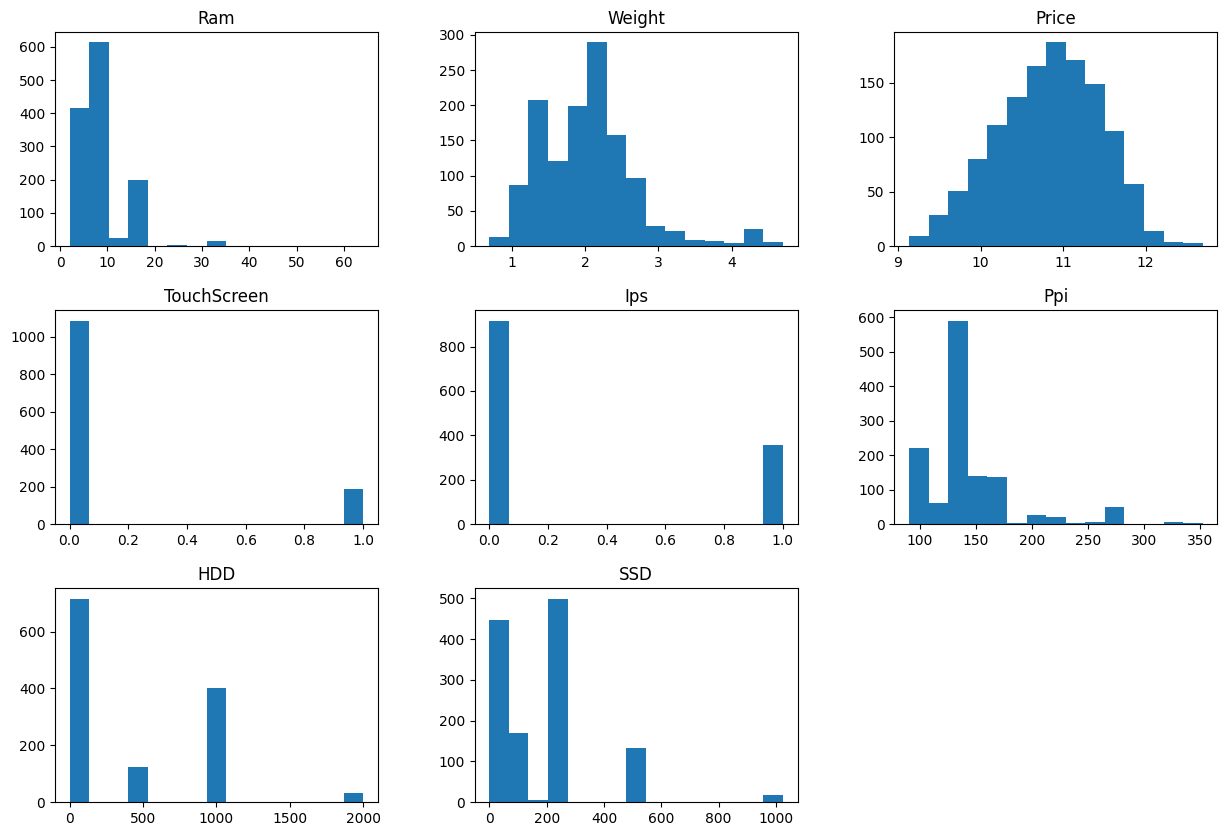

In [ ]:
df.hist(figsize=(15, 10), grid=False, bins=15)
plt.show()

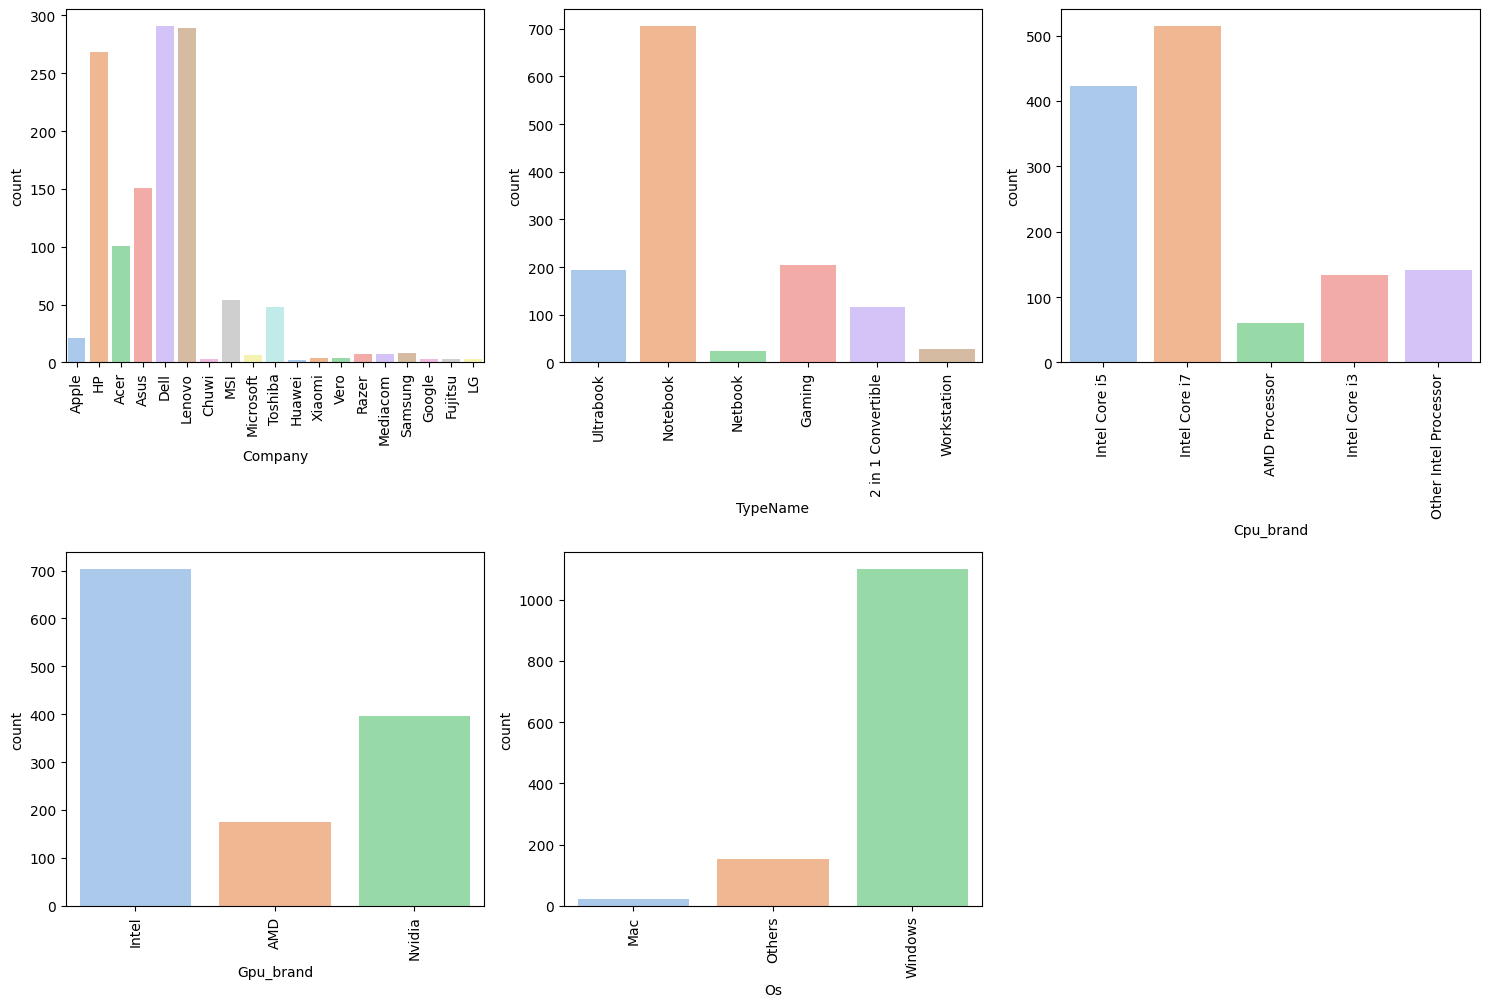

In [ ]:
categories = df[['Company', 'TypeName', 'Cpu_brand', 'Gpu_brand', 'Os']]

plt.figure(figsize = (15, 10))
for i, col in enumerate(categories.columns, 1):
  plt.subplot(2, 3, i)
  sns.countplot(x=categories[col], hue=categories[col], palette='pastel', legend=False)
  plt.tight_layout()
  plt.xticks(rotation=90)
plt.show()

In [ ]:
features = df.columns.drop('Price')
NUMERICAL = df[features].select_dtypes('number').columns
CATEGORICAL = df[features].select_dtypes('object').columns

In [ ]:
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1018, 12) (255, 12) (1018,) (255,)


In [ ]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        self.min = X[self.features].min()
        self.range = X[self.features].max()-self.min
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = (X[self.features]-self.min)/self.range
        return X_transformed


class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, drop='first'):
        self.features = features
        self.drop = drop

    def fit(self, X, y=None):
        self.encoder = OneHotEncoder(sparse=False, drop=self.drop)
        self.encoder.fit(X[self.features])
        return self

    def transform(self, X):
        X_transformed = pd.concat([X.drop(columns=self.features).reset_index(drop=True),
                                   pd.DataFrame(self.encoder.transform(X[self.features]),
                                                columns=self.encoder.get_feature_names_out(self.features))],
                                  axis=1)
        return X_transformed


class NeuralNetworkTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs=50, learning_rate=0.01, units1=32, units2=32, droupout_rate=0, verbose=0):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.units1 = units1
        self.units2 = units2
        self.droupout_rate = droupout_rate
        self.verbose = verbose
        self.model = None

    def fit(self, X, y=None):
        input_shape = (X.shape[1],)  # Форма входных данных на основе X

        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=self.units1, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dropout(rate=self.droupout_rate),
            tf.keras.layers.Dense(units=self.units2, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])

        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics=['mae'])

        model.fit(X, y, epochs=self.epochs, verbose=self.verbose)
        self.model = model
        return self

    def transform(self, X):
        # NeuralNetworkTrainer не изменяет данные, поэтому просто возвращаем X
        return X

    def predict(self, X):
        # Предсказать метки классов для новых данных X
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        return y_pred

    def score(self, X, y=None):
        # Оцените производительность модели на данных X и y
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        return mae

In [ ]:
# Optuna параметры для нейронной сети
def objective(trial):
  param = {
      'epochs': trial.suggest_categorical('epochs', [100, 200, 300, 400, 500]),
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
      'units1': trial.suggest_categorical('units1', [256, 512, 1024, 2048, 4096, 8192]),
      'units2': trial.suggest_categorical('units2', [128, 256, 512, 1024, 2048, 4096, 8192]),
      'droupout_rate': trial.suggest_categorical('droupout_rate', [0, 0.01, 0.03, 0.05, 0.1, 0.15]),
      'verbose': trial.suggest_categorical('verbose', [0])
  }

  neural_network = NeuralNetworkTrainer(**param)
  # конвейер с нейронной сетью
  pipeline = Pipeline([
      ('scaler', Scaler(NUMERICAL)),
      ('encoder', Encoder(CATEGORICAL)),
      ('neural_network', neural_network)
  ])

  pipeline.fit(X_train, y_train)
  val_mae = pipeline.score(X_train, y_train)

  return val_mae

In [ ]:
study = optuna.create_study(direction='minimize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=500)

Trial 13 finished with value: 0.08205747167977753 and parameters: {'epochs': 500, 'learning_rate': 7.028382994656258e-05, 'units1': 8192, 'units2': 2048, 'droupout_rate': 0.05, 'verbose': 0}. Best is trial 13 with value: 0.08205747167977753.

In [ ]:
param = {
    'epochs': 500,
    'learning_rate': 7.028382994656258e-05,
    'units1': 8192,
    'units2': 2048,
    'droupout_rate': 0.05,
    'verbose': 0
}

neural_network = NeuralNetworkTrainer(**param)
pipe = Pipeline([
    ('scaler', Scaler(NUMERICAL)),
    ('encoder', Encoder(CATEGORICAL)),
    ('neural_network_trainer', neural_network),
])

pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('scaler',
                 Scaler(features=Index(['Ram', 'Weight', 'TouchScreen', 'Ips', 'Ppi', 'HDD', 'SSD'], dtype='object'))),
                ('encoder',
                 Encoder(features=Index(['Company', 'TypeName', 'Cpu_brand', 'Gpu_brand', 'Os'], dtype='object'))),
                ('neural_network_trainer',
                 NeuralNetworkTrainer(droupout_rate=0.05, epochs=500,
                                      learning_rate=7.028382994656258e-05,
                                      units1=8192, units2=2048))])

In [ ]:
y_pred = pipe.predict(X_test)

8/8 [==============================] - 0s 28ms/step


In [ ]:
pipe.score(X_test, y_test)

8/8 [==============================] - 0s 28ms/step


0.2130462303807401

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

MAE = 0.2130462303807401


# Pipeline lesson practice

In [ ]:
df = pd.read_csv("CarPrice_Assignment.csv")

In [ ]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [ ]:
df['carwlh'] = df.carwidth + df.carlength + df.carheight
df = df.drop(['carwidth', 'carlength', 'carheight', 'CarName', 'car_ID', 'citympg', 'highwaympg'], axis=1)

In [ ]:
df['drivewheel'] = df['drivewheel'].replace("4wd", 'wdf')
df['fuelsystem'] = df['fuelsystem'].replace("2bbl", 'tbbi')
df['fuelsystem'] = df['fuelsystem'].replace("1bbl", 'obbl')
df['fuelsystem'] = df['fuelsystem'].replace("4bbl", 'fbbl')

df_dummie = pd.get_dummies(df, columns = ['aspiration', 'carbody', 'drivewheel', 'enginetype', 'cylindernumber', 'fuelsystem'])

In [ ]:
categories_new  = ['doornumber', 'enginelocation',
       'boreratio', 'stroke', 'compressionratio',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_rwd', 'drivewheel_wdf', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two','fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'fuelsystem_obbl', 'fuelsystem_spdi',
       'fuelsystem_spfi', 'fuelsystem_tbbi','fueltype','fuelsystem_fbbl','cylindernumber_eight',
       'enginetype_dohc','drivewheel_fwd','carbody_convertible','aspiration_turbo','aspiration_std']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in categories_new:
    df_dummie[feature] = le.fit_transform(df_dummie[feature])

In [ ]:
X = df_dummie.drop(['price'], axis = 1)
y = df_dummie['price']

X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
mmc = MinMaxScaler()

X_train = mmc.fit_transform(X_train)
X_test = mmc.transform(X_test)

## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
class GradientBoostingRegressorTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=1000, max_depth=8, learning_rate=0.01, loss='absolute_error'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.loss = loss
        self.model = None

    def fit(self, X, y=None):
        self.model = GradientBoostingRegressor(n_estimators=self.n_estimators, max_depth=self.max_depth, learning_rate=self.learning_rate, loss=self.loss)
        self.model.fit(X, y)
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        return y_pred

    def score(self, X, y=None):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        return mae


params = {
    "n_estimators": 1000,
    "max_depth": 8,
    "learning_rate": 0.01,
    "loss": "absolute_error",
}

ensemble = GradientBoostingRegressor(**params)

pipe = Pipeline([
    ('model', ensemble)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.01,
                                           loss='absolute_error', max_depth=8,
                                           n_estimators=1000))])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

MAE = 1377.3789654915174


In [ ]:
params = {
    "n_estimators": 1000,
    "max_depth": 8,
    "learning_rate": 0.01,
    "loss": "absolute_error",
}

ensemble = GradientBoostingRegressor(**params)
ensemble.fit(X_train, y_train)

print('MAE =', mean_absolute_error(y_test, ensemble.predict(X_test)))

MAE = 1375.0558754396936


## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
class RandomForestRegressorTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=1000, max_depth=8):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.model = None

    def fit(self, X, y=None):
        self.model = RandomForestRegressor(n_estimators=self.n_estimators, max_depth=self.max_depth)
        self.model.fit(X, y)
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        return y_pred

    def score(self, X, y=None):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        return mae


params = {
    "n_estimators": 1200,
    "max_depth": 9
}

forest = RandomForestRegressorTrainer(**params)

pipe = Pipeline([
    ('model', forest)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('model',
                 RandomForestRegressorTrainer(max_depth=9, n_estimators=1200))])

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

MAE = 1286.7550475175


In [ ]:
rf = RandomForestRegressor(n_estimators=1200, max_depth=9)
rf.fit(X_train, y_train)

print('MAE =', mean_absolute_error(y_test, rf.predict(X_test)))

MAE = 1287.6432665353993


## NeuralNetwork

In [ ]:
class NeuralNetworkTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, epochs=100, units1=100, units2=200, units3=100, droupout_rate=0, learning_rate=0.1):
        self.epochs = epochs
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3
        self.droupout_rate = droupout_rate
        self.learning_rate = learning_rate
        self.model = None

    def fit(self, X, y=None):
        input_shape = (X.shape[1],)

        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=self.units1, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dense(units=self.units2, activation='relu'),
            Dropout(rate=self.droupout_rate),
            tf.keras.layers.Dense(units=self.units3, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])

        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics=['mae'])

        model.fit(X, y, epochs=self.epochs, verbose=0)
        self.model = model
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        return y_pred

    def score(self, X, y=None):
        if self.model is None:
            raise ValueError("Модель не обучена")
        y_pred = self.model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        return mae


param = {
    'epochs': 500,
    'learning_rate': 0.01,
    'units1': 200,
    'units2': 100,
    'units3': 200,
    'droupout_rate': 0.40
}

neural_network = NeuralNetworkTrainer(**param)

pipe = Pipeline([
    ('model', neural_network)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('model',
                 NeuralNetworkTrainer(droupout_rate=0.4, epochs=500,
                                      learning_rate=0.01, units1=200,
                                      units2=100, units3=200))])

In [ ]:
y_pred = pipe.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

MAE = 1434.8491149485517


In [ ]:
input_shape = (X_train.shape[1],)
model4 = tf.keras.models.Sequential([
    Dense(units=200, activation='relu',
                    input_shape=input_shape),
    Dense(units=100, activation='relu'),
    Dropout(0.40),
    Dense(units=200, activation='relu'),
    Dense(units=1)
])

optimizer=Adam(learning_rate=0.01)
model4.compile(optimizer, loss=['mse'], metrics = ["mae"])

loss = model4.fit(X_train, y_train, epochs = 500, validation_data = (X_test, y_test), verbose=0)

In [ ]:
y_pred = model4.predict(X_test)
print('MAE =', mean_absolute_error(y_test, y_pred))

2/2 [==============================] - 0s 5ms/step
MAE = 1454.2241566310975
